In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit
import lmfit

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate, Multiply, Reshape, ActivityRegularization
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

from carl.learning.calibration import HistogramCalibrator, IsotonicCalibrator, SigmoidCalibrator, NDHistogramCalibrator
from carl.distributions.base import weighted_quantile

from awkde import GaussianKDE


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Translation between s and r

In [2]:
def s(r):
    return 1./(1. + r)

def r(s, epsilon=1.e-3):
    return (1.-s)/(s + epsilon)

# Data

In [40]:
# Benchmark
theta1 = 708
theta = 9
theta_score = 0

#X to take into account
X_indices_import = list(range(42))
n_features = len(X_indices_import)
X_indices = list(range(n_features))

# Data
data_dir = '../data'
figure_dir = '../figures/score_density_estimation'

# Thetas
thetas = np.load(data_dir + '/thetas/thetas_parameterized.npy')
delta_theta = thetas[theta] - thetas[theta1]
rotation_matrix = (np.array([[delta_theta[0], - delta_theta[1]],[delta_theta[1], delta_theta[0]]])
                  )#/ np.linalg.norm(delta_theta))
print(delta_theta)
print(rotation_matrix)

# Training, calibration and test samples
X_train = np.load(data_dir + '/unweighted_events/X_train_scoreregression.npy')
scores_train = np.load(data_dir + '/unweighted_events/scores_train_scoreregression.npy')

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')[::10, X_indices_import]
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')[:,::10]
r_calibration = weights_calibration[theta] / weights_calibration[theta1]

X_test = np.load(data_dir + '/unweighted_events/X_test.npy')[:,X_indices_import]
r_test = np.load(data_dir + '/unweighted_events/r_test.npy')[theta]
scores_test = np.load(data_dir + '/unweighted_events/scores_test.npy')[theta_score]
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)
X_test_transformed = scaler.transform(X_test)

# keras requires training data with the same output as the NN
scores_gradients_train = np.zeros((scores_train.shape[0], 2 + 2*n_features))
scores_gradients_train[:,:2] = scores_train

# 2d calibration plots
xi = np.linspace(-6.0, 15.0, 500)
yi = np.linspace(-6.0, 15.0, 500)

xx, yy = np.meshgrid(xi, yi)
scores_eval = np.asarray((xx.flatten(), yy.flatten())).T

# 1d calibration curbves
tt_eval = np.linspace(-10.,10.,1000)

[-0.89293227 -0.93229216]
[[-0.89293227  0.93229216]
 [-0.93229216 -0.89293227]]


In [4]:
# Covariance matrix over a subset of the X for the grad-adaptive approach
cov_X = np.cov(X_train_transformed[::,X_indices], rowvar=False)

# Score regression

In [5]:
def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x

    return f

def hidden_layers(n,
                  hidden_layer_size=100,
                  activation='tanh',
                  dropout_prob=0.0):
    r = []
    for k in range(n):
        if dropout_prob > 0.:
            s = stack_layer([
                Dropout(dropout_prob),
                Dense(hidden_layer_size, activation=activation)
            ])
        else:
            s = stack_layer([Dense(hidden_layer_size, activation=activation)])
        r.append(s)
    return stack_layer(r)

def loss_function_score_regression(y_true, y_pred):
    return losses.mean_squared_error(y_true[:,:2], y_pred[:,:2])

def make_regressor(n_hidden_layers=3,
                    hidden_layer_size=100,
                    activation='tanh',
                    dropout_prob=0.0):
    # Inputs
    input_layer = Input(shape=(42,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    score_layer = Dense(2, activation='linear')(hidden_layer)

    # gradients with respect to x... there must be a nicer way to do this?
    gradient0_layer = Lambda(lambda x: K.gradients(x[0][0], x[1])[0],
                            output_shape=(n_features,))([score_layer, input_layer])
    gradient1_layer = Lambda(lambda x: K.gradients(x[0][1], x[1])[0],
                            output_shape=(n_features,))([score_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([score_layer, gradient0_layer, gradient1_layer])

    # Combine outputs
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_score_regression,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [6]:
# Train score regression
regr = KerasRegressor(lambda: make_regressor(n_hidden_layers=2),
                      epochs=20, verbose=1, validation_split=0.2,
                      callbacks=[EarlyStopping(verbose=1, patience=3)])

regr.fit(X_train_transformed, scores_gradients_train)

Train on 7999812 samples, validate on 1999953 samples
Epoch 1/20
7999812/7999812 [==============================] - 438s 55us/step - loss: 0.0339 - val_loss: 0.0205
Epoch 2/20
7999812/7999812 [==============================] - 460s 58us/step - loss: 0.0204 - val_loss: 0.0190
Epoch 3/20
7999812/7999812 [==============================] - 486s 61us/step - loss: 0.0178 - val_loss: 0.0169
Epoch 4/20
7999812/7999812 [==============================] - 628s 79us/step - loss: 0.0166 - val_loss: 0.0152
Epoch 5/20
7999812/7999812 [==============================] - 515s 64us/step - loss: 0.0156 - val_loss: 0.0144
Epoch 6/20
7999812/7999812 [==============================] - 550s 69us/step - loss: 0.0153 - val_loss: 0.0136
Epoch 7/20
7999812/7999812 [==============================] - 557s 70us/step - loss: 0.0146 - val_loss: 0.0168
Epoch 8/20
7999812/7999812 [==============================] - 446s 56us/step - loss: 0.0145 - val_loss: 0.0131
Epoch 9/20
7999812/7999812 [==============================

In [41]:
# Evaluate on calibration sample
calibration_predictions = regr.predict(X_calibration_transformed)
that_calibration = calibration_predictions[:,:2]
tthat_calibration = that_calibration.dot(delta_theta)
that_rotated_calibration = that_calibration.dot(rotation_matrix)
gradients_calibration = calibration_predictions[:,2:].reshape((-1,n_features,2))
tgradients_calibration = gradients_calibration.dot(delta_theta)

that_calibration_carlinput = np.vstack((that_calibration, that_calibration))
print(that_calibration_carlinput.shape)
tthat_calibration_carlinput = np.hstack((tthat_calibration, tthat_calibration))
that_rotated_calibration_carlinput = np.vstack((that_rotated_calibration, that_rotated_calibration))
print(tthat_calibration_carlinput.shape)
y_calibration_carlinput = np.hstack((np.zeros(that_calibration.shape[0]), np.ones(that_calibration.shape[0])))
w_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

# Evaluate on test sample
that_test = regr.predict(X_test_transformed)[:,:2]
tthat_test = that_test.dot(delta_theta)
that_rotated_test = that_test.dot(rotation_matrix)

99955/99955 [==============================] - 2s 15us/step
(199910, 2)
(199910,)
48238/48238 [==============================] - 1s 15us/step


In [42]:
# Calculate KDE bandwidths.. for now only for 1 d case
grad_cov = cov_X.dot(tgradients_calibration[:,X_indices].T)
grad_cov_grad = np.sum(grad_cov[:,:] * tgradients_calibration[:,X_indices].T, axis=0)
bandwidths_tt = np.sqrt(np.copy(grad_cov_grad))
print(np.min(bandwidths_tt), np.mean(bandwidths_tt), np.max(bandwidths_tt))
bandwidths_tt = np.clip(bandwidths_tt, 0., np.mean(bandwidths_tt) * 10.)
#print(np.min(bandwidths_tt), np.mean(bandwidths_tt), np.max(bandwidths_tt))
bandwidths_tt /= np.mean(bandwidths_tt)
bandwidths_tt = np.clip(bandwidths_tt, 0.1,10.)
bandwidths_tt /= np.mean(bandwidths_tt)

print(np.min(bandwidths_tt), np.mean(bandwidths_tt), np.max(bandwidths_tt))

0.0 0.08780708100577146 92.86866069522685
0.15880700822199054 1.0 15.880700822199055


# Calibration method list

In [43]:
# list of tuples (label1, label2, contract_with_theta, tool, mode, settings)
# label1 and label2 are used in tables and plots
# contract_with_theta is a bool that defines whether to use delta_theta.score for 1d
#   density est. rather than 2d density estimation in score space
# tool can be 'carl' for the built-in calibration methods and 'kde'
#   for the adaptive KDE techniques (including the gradient one)
# mode can be 'dynamic_histo', 'histo', 'isotonic', ... for tool='carl', and
#   'fixed', 'adaptive', 'grad' for tool='kde'
# settings is a dict with settings passed to the Calibrator or GaussianKDE objects

calibrations = [] 

def _add(*args):
    assert len(args)==6
    calibrations.append(args)

# 2d Histogram calibration
_add('Fixed $t$ histogram', '$10^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(10,10)})
_add('', '$20^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(20,20)})
_add('', '$30^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(30,30)})
_add('', '$40^2$ equidistant bins', False, 'carl', 'histo',
     {'bins':(40,40)})
_add('', '$42^2$ optimized bins', False, 'carl', 'histo',
     {'bins':'optimized'})

# 2d histogram calibration (dynamic)
_add('Dynamic $t$ histogram', '$20 \cdot 5$ equidistant bins', False, 'carl', 'dynamic_histo',
     {'bins':(20,5)})
_add('', r'$50 \cdot 10$ equidistant bins', False, 'carl', 'dynamic_histo',
     {'bins':(50,10)})
_add('', r'$100 \cdot 20$ equidistant bins', False, 'carl', 'dynamic_histo',
     {'bins':(100,20)})
_add('', r'$102 \cdot 16$ optimized bins', False, 'carl', 'dynamic_histo',
     {'bins':'optimized'})

# 2d KDE
# _add('$t$ KDE', 'fixed bandwidth', False, 'kde', 'fixed', {})
# _add('', r'adaptive ($\alpha=0.25$)', False, 'kde', 'adaptive', {'alpha':0.25})
# _add('', r'adaptive ($\alpha=0.5$)', False, 'kde', 'adaptive', {'alpha':0.5})
# _add('', r'adaptive ($\alpha=0.75$)', False, 'kde', 'adaptive', {'alpha':0.75})
# _add('', r'adaptive ($\alpha=1$)', False, 'kde', 'adaptive', {'alpha':1.})

# 1d linear fit
_add(r'Local model fit', '', True, 'fit', '',
     {'bins':500})

# 1d histogram
_add(r'$t \cdot \Delta \theta$ histogram', '25 equidistant bins', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False})
_add('', '50 equidistant bins', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False})
_add('', '100 equidistant bins', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False})
_add('', '200 equidistant bins', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False})
_add('', '500 equidistant bins', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':False, 'variable_width':False})

_add('', '25 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '50 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '100 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '200 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '500 equidistant bins, linear interpolation', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})

_add('', '25 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '50 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '100 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '200 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '500 equidistant bins, spline interpolation', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})

_add('', '25 variable bins', True, 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':True})
_add('', '50 variable bins', True, 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':True})
_add('', '100 variable bins', True, 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':True})
_add('', '200 variable bins', True, 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':True})
_add('', '500 variable bins', True, 'carl', 'histo',
     {'bins':500, 'independent_binning':False, 'variable_width':True})

_add('', '146 optimized bins', True, 'carl', 'histo',
     {'bins':'optimized', 'independent_binning':True, 'variable_width':False})

# 1d KDE
# _add(r'$t \cdot \Delta \theta$ KDE', 'fixed bandwidth', True, 'kde', 'fixed', {})
# _add('', r'adaptive ($\alpha=0.25$)', True, 'kde', 'adaptive', {'alpha':0.25})
# _add('', r'adaptive ($\alpha=0.5$)', True, 'kde', 'adaptive', {'alpha':0.5})
# _add('', r'adaptive ($\alpha=0.75$)', True, 'kde', 'adaptive', {'alpha':0.75})
# _add('', r'adaptive ($\alpha=1$)', True, 'kde', 'adaptive', {'alpha':1.})

# grad-adaptive KDE
# _add(r'$t \cdot \Delta \theta$ KDE', r'grad-adaptive ($\beta=0.2$)', True, 'kde', 'grad', {'factor':0.2})
# _add('', r'grad-adaptive ($\beta=0.5$)', True, 'kde', 'grad', {'factor':0.5})
# _add('', r'grad-adaptive ($\beta=1$)', True, 'kde', 'grad', {'factor':1.})
# _add('', r'grad-adaptive ($\beta=2$)', True, 'kde', 'grad', {'factor':2.})
# _add('', r'grad-adaptive ($\beta_{\text{num}} = 1.66$, $\beta_{\text{den}} = 1.13$)',
#      True, 'kde', 'grad', {'factor':'auto'})

plot_labels = []
last_label1 = ''
for cal in calibrations:
    label2_string = '' if cal[1] == '' else ', ' + cal[1]
    if cal[0] == '':
        plot_labels.append(last_label1 + label2_string)
    else:
        plot_labels.append(cal[0] + label2_string)
        last_label1 = cal[0]


# Density estimation methods

In [44]:
def density_estimation_carl_1d(mode, settings, return_histos=False):
    
    # Fit carl Calibrator object
    if mode in ['histogram', 'histo']:
        settings_ = copy.deepcopy(settings)
        bins_ = settings_.pop('bins', 'auto')
        if bins_=='optimized':
            bins_ = [np.concatenate(([-100000.,-100.,-70.,-50.,-40.,-30.,-25.,-22.],
                                          np.linspace(-20.,-11.,10), # steps of 1.
                                          np.linspace(-10.,-5.5,10), # steps of 0.5
                                          np.linspace(-5.,-2.2,15), # steps of 0.2
                                          np.linspace(-2.,-1.1,10), # steps of 0.1
                                          np.linspace(-1.,1.,41), # steps of 0.05
                                          np.linspace(1.1,2.,10), # steps of 0.1
                                          np.linspace(2.2,5.,15), # steps of 0.2
                                          np.linspace(5.5,10.,10), # steps of 0.5
                                          np.linspace(11.,20.,10), # steps of 1.
                                          [22.,25.,30.,40.,50.,70.,100.,100000.]))]
        settings_['bins']=bins_
        calibrator = HistogramCalibrator(**settings_)
        
    elif mode == 'isotonic':
        calibrator = IsotonicCalibrator(**settings)
        
    elif mode == 'sigmoid':
        calibrator = SigmoidCalibrator(**settings)
        
    else:
        raise ValueError('Unknown mode "' + mode + '"')
    
    calibrator.fit(tthat_calibration_carlinput, y_calibration_carlinput,
                   sample_weight=w_calibration_carlinput)
    
    # Nominator and denominator histograms
    if mode == 'histo' and return_histos:
        histo_num = calibrator.calibrator0.histogram_
        histo_den = calibrator.calibrator1.histogram_
        edges_num = calibrator.calibrator0.edges_[0]
        edges_den = calibrator.calibrator1.edges_[0]

    # Calibration curve
    s_hat_calibrated_eval = calibrator.predict(tt_eval.reshape((-1,)))
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    s_hat_calibrated_test = calibrator.predict(tthat_test.reshape((-1,)))
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    if mode == 'histo' and return_histos:
        return r_hat_calibrated_eval, r_hat_calibrated_test, histo_num, edges_num, histo_den, edges_den
    return r_hat_calibrated_eval, r_hat_calibrated_test

In [45]:
def density_estimation_fit_1d(mode, settings):
    
    # Calibration function
    def calibration_function(x, a, b):
        logr_ = a + b*x # linear model
        s_ = s(np.exp(logr_))
        return s_
    
    # First, fit histogram
    calibrator = HistogramCalibrator(**settings)
    
    calibrator.fit(tthat_calibration_carlinput, y_calibration_carlinput,
                   sample_weight=w_calibration_carlinput)
    s_hat_calibrated_calibration = calibrator.predict(tthat_calibration)
    
    # Fit calibration function to (tthat, s calibrated)
    model = lmfit.Model(calibration_function)
    params = model.make_params()
    params['a'].set(value=0.,min=-1.,max=1.,brute_step=0.05)
    params['b'].set(value=1.,min=0.,max=2.,brute_step=0.05)
    result = model.fit(s_hat_calibrated_calibration,
                       params,
                       x=tthat_calibration,
                       method='brute',
                       fit_kws={})
    print(result.fit_report())
    best_a = result.best_values['a']
    best_b = result.best_values['b']

    # Calibration curve
    s_hat_calibrated_eval = calibration_function(tt_eval.reshape((-1,)), best_a, best_b)
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    s_hat_calibrated_test = calibration_function(tthat_test.reshape((-1,)), best_a, best_b)
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)


In [46]:
def density_estimation_kde_1d(mode, settings):
    
    # Settings
    settings_ = copy.deepcopy(settings)
    bandwidth_num = None
    bandwidth_den = None
    
    if mode == 'fixed':
        settings_ = {'alpha':None}
        
    elif mode == 'adaptive':
        pass
    
    elif mode == 'grad':
        factor = settings_.pop('factor', 1.)
        if factor=='auto':
            bandwidth_num = 1.66 * (bandwidths_tt)
            bandwidth_den = 1.13 * (bandwidths_tt)
        else:
            bandwidth_num = factor * (bandwidths_tt)
            bandwidth_den = factor * (bandwidths_tt)
        
    else:
        raise ValueError(mode)
    
    pdf_nom = GaussianKDE(**settings_)
    pdf_den = GaussianKDE(**settings_)

    # Fit
    pdf_nom.fit(tthat_calibration.reshape((-1,1)),
                weights=weights_calibration[theta,::],
                bandwidth=bandwidth_num)
    pdf_den.fit(tthat_calibration.reshape((-1,1)),
                weights=weights_calibration[theta1,::],
                bandwidth=bandwidth_den)
        
    # Extract bandwidths (for debugging purposes)
    if mode in ['adaptive', 'grad']:
        actual_bandwidths_nom = 1. / pdf_nom._inv_loc_bw
        actual_bandwidths_den = 1. / pdf_den._inv_loc_bw
    else:
        actual_bandwidths_nom = actual_bandwidths_den = np.ones_like(tthat_calibration)
    
    print('Bandwidth means:', np.mean(actual_bandwidths_nom), np.mean(actual_bandwidths_den))
    
    # Calibration curve
    p_hat_nom_eval = pdf_nom.predict(tt_eval.reshape((-1,1)))
    p_hat_den_eval = pdf_den.predict(tt_eval.reshape((-1,1)))
    r_hat_calibrated_eval = p_hat_nom_eval / p_hat_den_eval
    r_hat_calibrated_eval[p_hat_den_eval<=0.] = 1.
    
    # Test sample
    p_hat_nom_test = pdf_nom.predict(tthat_test.reshape((-1,1)))
    p_hat_den_test = pdf_den.predict(tthat_test.reshape((-1,1)))
    r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
    r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

In [47]:
def density_estimation_carl_2d(mode, settings):
    
    # Fit carl Calibrator object
    if mode not in ['dynamic_histogram', 'dynamic_histo', 'histogram', 'histo']:
        raise ValueError('Unknown 2d mode "' + mode + '"')
        
    settings_ = copy.deepcopy(settings)
    
    dynamic_mode = (mode in ['dynamic_histogram', 'dynamic_histo'])
    
    bins_ = settings_.pop('bins', 'auto')
    range_ = settings_.pop('range', None)
    
    if bins_=='optimized':
        
        if dynamic_mode:
            bins_main = np.concatenate(([-100000.,-20.,-15.,-12.,-10.,-8.,-7.,-6.,-5.5,],
                                      np.linspace(-5.,-2.25,12), # steps of 0.25
                                      np.linspace(-2.,-1.1,10), # steps of 0.1
                                      np.linspace(-1.,1.,41), # steps of 0.05
                                      np.linspace(1.1,2.,10), # steps of 0.1
                                      np.linspace(2.25,5.,12), # steps of 0.25
                                   [5.5,6.,7.,8.,10.,12.,15.,20.,100000.]))
            bins_other = np.array([-100000.,-20.,-10.,-5.,-3.,-2.,-1.,-0.5,0.,0.5,1.,2.,3.,5.,10.,20.,100000.])
            bins_ = (bins_main, bins_other)
            range_ = (np.array((-100000.,100000.)),np.array((-100000.,100000.)))
            
        else:
            bins_ = np.concatenate(([-100000.,-20.,-15.,-10.,-8.,-6.],
                                   np.linspace(-5.,-2.5,6),
                                   np.linspace(-2.,-1.2,5),
                                   np.linspace(-1.,1.,21),
                                   np.linspace(1.2,2.0,5),
                                   np.linspace(2.5,5.,6),
                                   [6.,8.,10.,15.,20.,100000.]))
            bins_ = (bins_, bins_)
            range_ = (np.array((-100000.,100000.)),np.array((-100000.,100000.)))

    calibrator = NDHistogramCalibrator(bins=bins_, range=range_)
    
    calibrator.fit(that_rotated_calibration_carlinput if dynamic_mode else that_calibration_carlinput,
                   y_calibration_carlinput,
                   sample_weight=w_calibration_carlinput)

    # Calibration curve
    s_hat_calibrated_eval = calibrator.predict(scores_eval.dot(rotation_matrix) if dynamic_mode else scores_eval)
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    s_hat_calibrated_test = calibrator.predict(that_rotated_test if dynamic_mode else that_test)
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

In [48]:
def density_estimation_kde_2d(mode, settings):
    
    # Settings
    settings_ = copy.deepcopy(settings)
    bandwidth_num = None
    bandwidth_den = None
    
    if mode == 'fixed':
        settings_ = {'alpha':None}
        
    elif mode == 'adaptive':
        pass
    
    elif mode == 'grad':
        factor = settings_.pop('factor', 1.)
        if factor=='auto':
            bandwidth_num = 1.66 * (bandwidths_tt)
            bandwidth_den = 1.13 * (bandwidths_tt)
        else:
            bandwidth_num = factor * (bandwidths_tt)
            bandwidth_den = factor * (bandwidths_tt)
        
    else:
        raise ValueError(mode)
    
    pdf_nom = GaussianKDE(**settings_)
    pdf_den = GaussianKDE(**settings_)

    # Fit
    pdf_nom.fit(that_calibration,
                weights=weights_calibration[theta,::],
                bandwidth=bandwidth_num)
    pdf_den.fit(that_calibration,
                weights=weights_calibration[theta1,::],
                bandwidth=bandwidth_den)
        
    # Extract bandwidths (for debugging purposes)
    if mode in ['adaptive', 'grad']:
        actual_bandwidths_nom = 1. / pdf_nom._inv_loc_bw
        actual_bandwidths_den = 1. / pdf_den._inv_loc_bw
    else:
        actual_bandwidths_nom = actual_bandwidths_den = np.ones(that_calibration.shape[0])
    
    print('Bandwidth means:', np.mean(actual_bandwidths_nom), np.mean(actual_bandwidths_den))
    
    # Calibration curve
    p_hat_nom_eval = pdf_nom.predict(scores_eval)
    p_hat_den_eval = pdf_den.predict(scores_eval)
    r_hat_calibrated_eval = p_hat_nom_eval / p_hat_den_eval
    r_hat_calibrated_eval[p_hat_den_eval<=0.] = 1.
    
    # Test sample
    p_hat_nom_test = pdf_nom.predict(that_test)
    p_hat_den_test = pdf_den.predict(that_test)
    r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
    r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

# Main loop

In [49]:
from carl.learning.calibration import HistogramCalibrator

r_hat_calibrated_eval_list = []
r_hat_calibrated_test_list = []
mse_logr_list = []

for i, (label1, label2, contract, tool, mode, settings) in enumerate(calibrations):
    
    # Do calibration
    time_start = time.clock()
    
    if contract:
        if tool == 'carl':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_carl_1d(mode, settings)
        elif tool == 'kde':
            r_hat_calibrated_eval, r_hat_calibrated_test = None, None # density_estimation_kde_1d(mode, settings)
            
        elif tool == 'fit':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_fit_1d(mode, settings)
        else:
            raise ValueError(tool)
            
    else:
        if tool == 'carl':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_carl_2d(mode, settings)
        elif tool == 'kde':
            r_hat_calibrated_eval, r_hat_calibrated_test = None, None #density_estimation_kde_2d(mode, settings)
        else:
            raise ValueError(tool)
        
    calibration_time = time.clock() - time_start
        
    # Store results for plots
    r_hat_calibrated_eval_list.append(r_hat_calibrated_eval)
    r_hat_calibrated_test_list.append(r_hat_calibrated_test)
    
    # Metrics
    try:
        mse_logr = mean_squared_error(np.log(r_test), np.log(r_hat_calibrated_test))
    except (ValueError, AttributeError):
        mse_logr = None
    mse_logr_list.append(mse_logr)
    
    print(i, label1, label2, ': MSE =', mse_logr, 'in', calibration_time, 's')

0 Fixed $t$ histogram $10^2$ equidistant bins : MSE = 0.26733127601233736 in 0.04838699999891105 s
1  $20^2$ equidistant bins : MSE = 0.13171634900919568 in 0.05609800000092946 s
2  $30^2$ equidistant bins : MSE = 0.12798406525683595 in 0.05233399999997346 s
3  $40^2$ equidistant bins : MSE = 0.0729630891157046 in 0.05888600000071165 s
4  $42^2$ optimized bins : MSE = 0.01151529047187566 in 0.06972400000086054 s
5 Dynamic $t$ histogram $20 \cdot 5$ equidistant bins : MSE = 0.15188989433746033 in 0.06455099999948288 s
6  $50 \cdot 10$ equidistant bins : MSE = 0.03592672706079333 in 0.059632000000419794 s
7  $100 \cdot 20$ equidistant bins : MSE = 0.020835725304876998 in 0.0667570000005071 s
8  $102 \cdot 16$ optimized bins : MSE = 0.009009184124477604 in 0.07260300000052666 s
[[Model]]
    Model(calibration_function)
[[Fit Statistics]]
    # function evals   = 1602
    # data points      = 99955
    # variables        = 2
    chi-square         = 1391.701
    reduced chi-square = 0.014


In [66]:
from carl.learning.calibration import HistogramCalibrator

need_fixes = [27]

for i, (label1, label2, contract, tool, mode, settings) in enumerate(calibrations):
    
    if i not in need_fixes:
        continue
    
    # Do calibration
    time_start = time.clock()
    
    if contract:
        if tool == 'carl':
            if mode == 'histo':
                r_hat_calibrated_eval, r_hat_calibrated_test, histo_num, edges_num, histo_den, edges_den \
                = density_estimation_carl_1d(mode, settings, return_histos=True)
                print('yo')
            else:
                r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_carl_1d(mode, settings)
        elif tool == 'kde':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_kde_1d(mode, settings)
        elif tool == 'fit':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_fit_1d(mode, settings)
        else:
            raise ValueError(tool)
            
    else:
        if tool == 'carl':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_carl_2d(mode, settings)
        elif tool == 'kde':
            r_hat_calibrated_eval, r_hat_calibrated_test = density_estimation_kde_2d(mode, settings)
        else:
            raise ValueError(tool)
        
    calibration_time = time.clock() - time_start
        
    # Store results for plots
    r_hat_calibrated_eval_list.append(r_hat_calibrated_eval)
    r_hat_calibrated_test_list.append(r_hat_calibrated_test)
    
    # Metrics
    mse_logr = mean_squared_error(np.log(r_test), np.log(r_hat_calibrated_test))
    mse_logr_list.append(mse_logr)
    
    print(i, label1, label2, ': MSE =', mse_logr, 'in', calibration_time, 's')

yo
27  50 variable bins : MSE = 0.014006262061444676 in 0.9802220000001398 s


# Result table

In [84]:
class TablePrinter:
    
    def __init__(self, precisions, header=None):
        
        # Functions for metrics
        self.n_metrics = len(precisions)
        self.precisions = precisions
        
        # Total table and current block
        self.table = ''
        self.block_entries = []

        # Formatting options
        self.indent = '   '
        self.col_sep = ' & '
        self.end_row = r' \\'
        self.midrule = r'\midrule'
        self.end_line = u'\n'
        self.emphasis_begin = r'\mathbf{'
        self.emphasis_end = r'}'
        
        # Header
        self.table = ''
        if header is not None:
            self.table += self.indent + header + self.end_row + self.end_line
    
    
    def finalise_block(self):

        # Find best performance
        block_metrics = [line[2:] for line in self.block_entries]
        block_metrics = np.array(block_metrics)
        block_best = []
        for i in range(self.n_metrics):
            try:
                block_best.append(np.nanargmin(block_metrics[:,i]))
            except (ValueError, TypeError):
                block_best.append(-1)

        # Format entries
        text = ''
        for i, line in enumerate(self.block_entries):
            
            # Labels
            text += self.indent + line[0] + self.col_sep + line[1] + self.col_sep
            
            # Metrics
            for j in range(self.n_metrics):
                if line[j+2] is not None and np.isfinite(line[j + 2]):
                    text += self.format_number(line[j + 2], self.precisions[j], emphasize=(i == block_best[j]))
                if j == len(line) - 3:
                    text += self.end_row + self.end_line
                else:
                    text += self.col_sep

        # Add to document and reset for next block
        self.table += text
        self.block_entries = []
    
    
    def new_block(self):
        self.finalise_block()
        self.table += self.indent + self.midrule + self.end_line
    
    
    def format_number(self,
                      number,
                      precision=2,
                      trailing_zeros=True,
                      fix_minus_zero=True,
                      latex_math_mode=True,
                      emphasize=False):
        if precision == 0:
            temp =  str(int(round(number,precision)))
        elif trailing_zeros:
            temp =  ('{:.' + str(precision) + 'f}').format(round(number,precision))
        else:
            temp =  str(round(number,precision))
        if fix_minus_zero and len(temp) > 0:
            if temp[0] == '-' and float(temp) == 0.:
                temp = temp[1:]
        if latex_math_mode:
            if emphasize:
                temp = '$\mathbf{' + temp + '}$'
            else:
                temp = '$' + temp + '$'
        elif emphasize:
            temp = r'\emph{' + temp + r'}'
        return temp
    
    
    def add(self, col1, col2, values, folder='parameterized'):
        
        # Label columns
        line = [col1, col2] + values
        self.block_entries.append(line)
    
    
    def print(self):
        self.finalise_block()
        return self.table

In [85]:
table = TablePrinter(precisions=[3])

for i, ((label1, label2, _, _, _, _), mse) in enumerate(zip(calibrations,
                                                             mse_logr_list)):
    
    if i > 0 and label1 != '':
        table.new_block()
        
    table.add(label1, label2, [mse])
    
print(table.print())

   $t$ histogram & $10^2$ equidistant bins & $0.229$ \\
    & $20^2$ equidistant bins & $0.211$ \\
    & $30^2$ equidistant bins & $0.102$ \\
    & $40^2$ equidistant bins & $0.108$ \\
    & $42^2$ optimized bins & $\mathbf{0.010}$ \\
   \midrule
   $t$ KDE & fixed bandwidth &  \\
    & adaptive ($\alpha=0.25$) &  \\
    & adaptive ($\alpha=0.5$) &  \\
    & adaptive ($\alpha=0.75$) &  \\
    & adaptive ($\alpha=1$) &  \\
   \midrule
   Local model fit &  & $\mathbf{0.057}$ \\
   \midrule
   $t \cdot \Delta \theta$ histogram & 25 equidistant bins & $0.124$ \\
    & 50 equidistant bins & $0.041$ \\
    & 100 equidistant bins & $0.024$ \\
    & 200 equidistant bins & $0.012$ \\
    & 500 equidistant bins & $0.009$ \\
    & 25 equidistant bins, linear interpolation & $0.164$ \\
    & 50 equidistant bins, linear interpolation & $0.045$ \\
    & 100 equidistant bins, linear interpolation & $0.025$ \\
    & 200 equidistant bins, linear interpolation & $0.010$ \\
    & 500 equidistant bins, l

# Density estimation plots

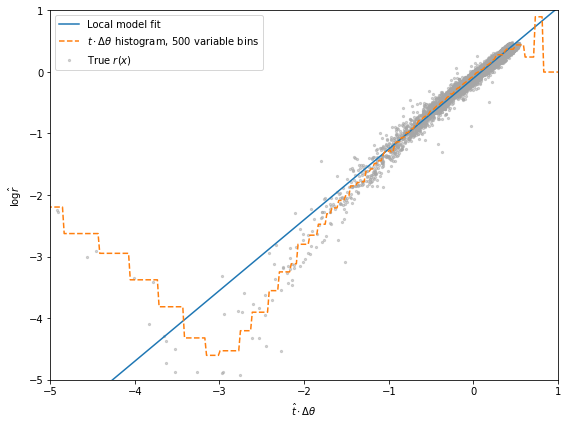

In [96]:
show_indices = [10,30]
linestyles=(['-'] + ['--',':','-.'] * 5)[:len(show_indices)]

plt.figure(figsize=(8.,6.))

for i, ls in zip(show_indices, linestyles):
    plt.plot(tt_eval, np.log(r_hat_calibrated_eval_list[i]), ls=ls,
             label=plot_labels[i])

plt.scatter(tthat_test[::5], np.log(r_test[::5]), c='0.65', s=5., alpha=0.5, zorder=-10,
            label='True $r(x)$')

plt.xlabel(r'$\hat{t} \cdot \Delta \theta$')
plt.ylabel('$\log \hat{r}$')
plt.legend(loc='upper left')
plt.xlim(-5,1.)
plt.ylim(-5.,1.)

plt.tight_layout()
plt.savefig(figure_dir + '/density_estimation_curves.pdf')

# 2d density estimation histograms

In [29]:
print(xi.shape)
print(yi.shape)
print(r_hat_calibrated_eval_list[8].shape)

(200,)
(200,)
(40000,)


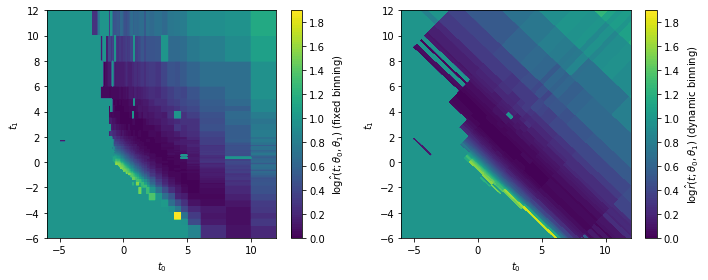

In [39]:
show=[4,8]
labels=['fixed binning', 'dynamic binning']

plt.figure(figsize=(10.,4.))

for i, (ind, label) in enumerate(zip(show,labels)):
    plt.subplot(1,len(show),i+1)

    cs = plt.contourf(xi, yi, np.clip(r_hat_calibrated_eval_list[ind].reshape((len(xi), len(yi))), 0., 1.9),
                      100, cmap="viridis", vmin=0.0, vmax=1.9)
    cbar = plt.colorbar()
    
    plt.xlim(-6.,12.)
    plt.ylim(-6.,12.)
    
    plt.xlabel('$t_0$')
    plt.ylabel('$t_1$')
    cbar.set_label(r'$\log \hat{r}(t; \theta_0, \theta_1)$ (' + label + ')')

plt.tight_layout()
plt.savefig(figure_dir + '/density_estimation_2d.pdf')

# Individual histograms for numerator and denominator

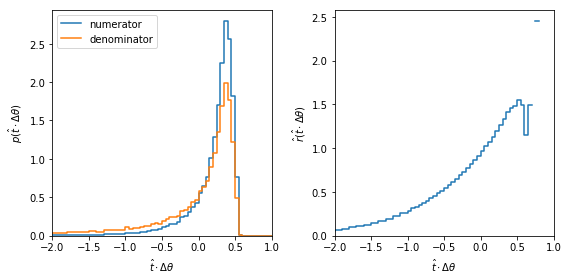

In [50]:
num_hist_ = np.hstack([histo_num, [0.]])
den_hist_ = np.hstack([histo_den, [0.]])

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.step(edges_num, num_hist_,
         where='post',
         alpha=1., fillstyle='none',
         color='C0', label='numerator')
plt.step(edges_den, den_hist_,
         where='post',
         alpha=1., fillstyle='none',
         color='C1', label='denominator')
plt.xlabel(r'$\hat{t} \cdot \Delta \theta$')
plt.ylabel(r'$p(\hat{t} \cdot \Delta \theta)$')
plt.xlim(-2.,1.)
plt.ylim(0.,None)
plt.legend()

plt.subplot(1,2,2)
plt.step(edges_num, num_hist_ / den_hist_,
         where='post', fillstyle='none',
         color='C0', label='numerator')
plt.xlabel(r'$\hat{t} \cdot \Delta \theta$')
plt.ylabel(r'$\hat{r}(\hat{t} \cdot \Delta \theta)$')
plt.xlim(-2.,1.)
plt.ylim(0.,None)

plt.tight_layout()
plt.savefig(figure_dir + '/density_estimation_histograms.pdf')

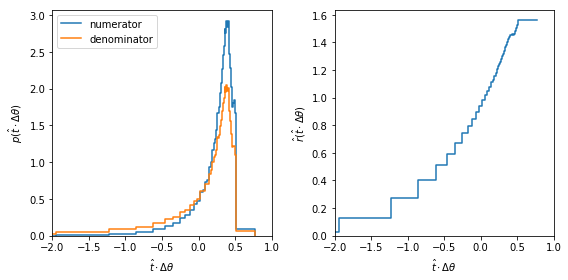

In [67]:
num_hist_ = np.hstack([histo_num, [0.]])
den_hist_ = np.hstack([histo_den, [0.]])

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.step(edges_num, num_hist_,
         where='post',
         alpha=1., fillstyle='none',
         color='C0', label='numerator')
plt.step(edges_den, den_hist_,
         where='post',
         alpha=1., fillstyle='none',
         color='C1', label='denominator')
plt.xlabel(r'$\hat{t} \cdot \Delta \theta$')
plt.ylabel(r'$p(\hat{t} \cdot \Delta \theta)$')
plt.xlim(-2.,1.)
plt.ylim(0.,None)
plt.legend()

plt.subplot(1,2,2)
plt.step(edges_num, num_hist_ / den_hist_,
         where='post', fillstyle='none',
         color='C0', label='numerator')
plt.xlabel(r'$\hat{t} \cdot \Delta \theta$')
plt.ylabel(r'$\hat{r}(\hat{t} \cdot \Delta \theta)$')
plt.xlim(-2.,1.)
plt.ylim(0.,None)

plt.tight_layout()
plt.show()